In [1]:
from evautils import sequtils
import numpy as np
from collections import OrderedDict
import h5py
import gzip

In [2]:
def load_sequences(seqfile):
    seqs = OrderedDict()
    fp = gzip.open(seqfile, "rb")
    print("#Loading " + seqfile + " ...")
    for line in fp:
        line=line.decode('utf8').split()
        seqs[line[0]] = line[1]
    fp.close()
    print("#Loaded " + str(len(seqs)) + " sequences from " + seqfile)
    return seqs

In [3]:
MOTIF_MATCHES_FILE = '/users/eprakash/git/interpret-benchmark/data/dnase_positives/common_scripts/A549/sequences/fimo_out/fimo.txt'
SEQ_FILE = '/users/eprakash/git/interpret-benchmark/data/dnase_positives/common_scripts/A549/sequences/top_10k_sim_positives.txt.gz'
SCORES_FILE='/users/eprakash/git/interpret-benchmark/scripts/deepsea_beluga/A549/sim_pos_and_neg.h5'

motif_matches = sequtils.load_fimo_motif_matches(MOTIF_MATCHES_FILE, True)
seqs=load_sequences(SEQ_FILE)

#Loading /users/eprakash/git/interpret-benchmark/data/dnase_positives/common_scripts/A549/sequences/fimo_out/fimo.txt ...
#Loaded 2102956 motif matches in 744982 sequences
#Loading /users/eprakash/git/interpret-benchmark/data/dnase_positives/common_scripts/A549/sequences/top_10k_sim_positives.txt.gz ...
#Loaded 10000 sequences from /users/eprakash/git/interpret-benchmark/data/dnase_positives/common_scripts/A549/sequences/top_10k_sim_positives.txt.gz


In [4]:
for key in list(motif_matches.keys()):
    if key not in list(seqs.keys()):
        del motif_matches[key]

In [5]:
h5f = h5py.File(SCORES_FILE,'r')

deeplift_rcrs_allzeros_scores=np.array(h5f.get("deeplift-rcrs_ref:allzeros"))
deeplift_rcrs_avgc_scores=np.array(h5f.get("deeplift-rcrs_ref:avgc"))
deeplift_rcrs_shuff10_scores=np.array(h5f.get("deeplift-rcrs_ref:shuff-10"))
deeplift_rcrs_shuff20_scores=np.array(h5f.get("deeplift-rcrs_ref:shuff-20"))

deeplift_rs_allzeros_scores=np.array(h5f.get("deeplift-rs_ref:allzeros"))
deeplift_rs_avgc_scores=np.array(h5f.get("deeplift-rs_ref:avgc"))
deeplift_rs_shuff10_scores=np.array(h5f.get("deeplift-rs_ref:shuff-10"))
deeplift_rs_shuff20_scores=np.array(h5f.get("deeplift-rs_ref:shuff-20"))

grad_times_input_allzeros_scores = np.array(h5f.get("gradtimesinp_ref:allzeros"))
ism_scores = np.array(h5f.get("ism"))

ig10_shuff10_scores = np.array(h5f.get("ig-10_ref:shuff-10"))
ig10_shuff20_scores =np.array(h5f.get("ig-10_ref:shuff-20"))
ig20_shuff10_scores =np.array(h5f.get("ig-20_ref:shuff-10"))
ig20_shuff20_scores =np.array(h5f.get("ig-20_ref:shuff-20"))

seqids = [x.decode('utf-8') for x in np.array(h5f.get("seqids"))]
h5f.close()

method_to_saved_scores = OrderedDict([('grad_times_input', grad_times_input_allzeros_scores),
                                      ('deeplift_rcrs_allzeros', deeplift_rcrs_allzeros_scores),
                                      ('deeplift_rcrs_avgc', deeplift_rcrs_avgc_scores),
                                      ('deeplift_rcrs_shuff10', deeplift_rcrs_shuff10_scores),
                                      ('deeplift_rcrs_shuff20', deeplift_rcrs_shuff20_scores),
                                      ('deeplift_rs_allzeros', deeplift_rs_allzeros_scores),
                                      ('deeplift_rs_avgc', deeplift_rs_avgc_scores),
                                      ('deeplift_rs_shuff10', deeplift_rs_shuff10_scores),
                                      ('deeplift_rs_shuff20', deeplift_rs_shuff20_scores),
                                      ('ig10_shuff10', ig10_shuff10_scores),
                                      ('ig10_shuff20', ig10_shuff20_scores),
                                      ('ig20_shuff10', ig20_shuff10_scores),
                                      ('ig20_shuff20', ig20_shuff20_scores),
                                      ('ism', ism_scores)])

In [6]:
relevant_indices_list, relevant_labels_list=sequtils.get_relevant_labels_in_order_of_scores(seqids, motif_matches)

Motif matches sequences are 10000
Supplied labels are 10000


In [7]:
def one_hot_encode_along_channel_axis(sequence):
    to_return = np.zeros((len(sequence),4), dtype=np.int8)
    seq_to_one_hot_fill_in_array(zeros_array=to_return,
                                 sequence=sequence, one_hot_axis=1)
    return to_return

def seq_to_one_hot_fill_in_array(zeros_array, sequence, one_hot_axis):
    assert one_hot_axis==0 or one_hot_axis==1
    if (one_hot_axis==0):
        assert zeros_array.shape[1] == len(sequence)
    elif (one_hot_axis==1): 
        assert zeros_array.shape[0] == len(sequence)
    #will mutate zeros_array
    for (i,char) in enumerate(sequence):
        if (char=="A" or char=="a"):
            char_idx = 0
        elif (char=="C" or char=="c"):
            char_idx = 1
        elif (char=="G" or char=="g"):
            char_idx = 2
        elif (char=="T" or char=="t"):
            char_idx = 3
        elif (char=="N" or char=="n"):
            continue #leave that pos as all 0's
        else:
            raise RuntimeError("Unsupported character: "+str(char))
        if (one_hot_axis==0):
            zeros_array[char_idx,i] = 1
        elif (one_hot_axis==1):
            zeros_array[i,char_idx] = 1
            
onehot_data = np.array([one_hot_encode_along_channel_axis(seqs[label]) for label in relevant_labels_list])

chr22:42780110-42780510

deeplift_rcrs_shuff20


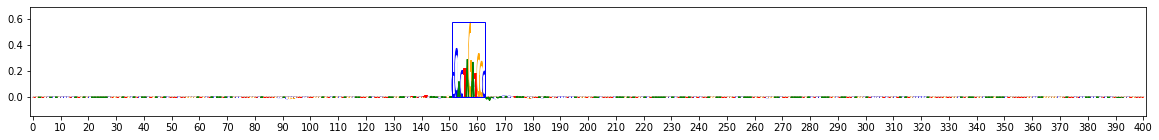

deeplift_rs_shuff20


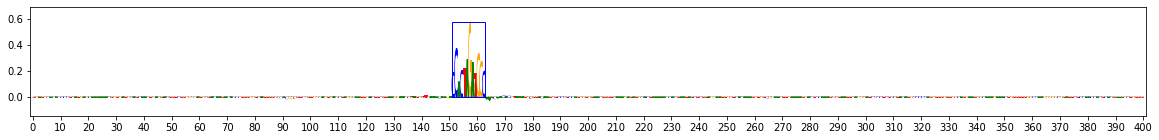

grad_times_input


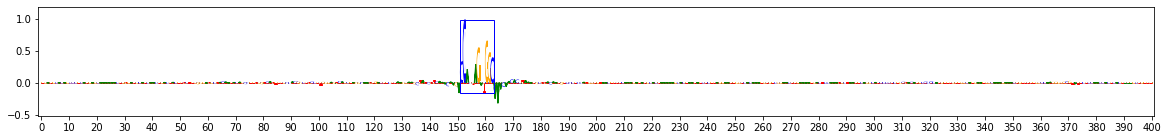

ism


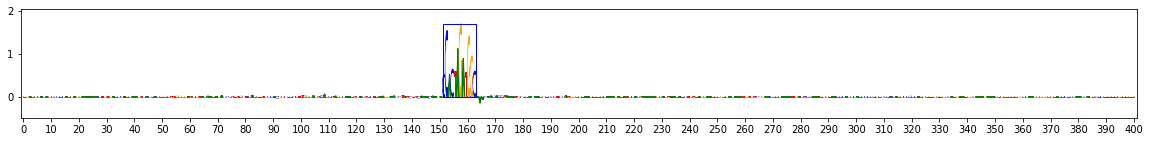

In [13]:
%matplotlib inline
from deeplift.visualization import viz_sequence
examples = ['chr22:42780110-42780510']
methods = ['deeplift_rcrs_shuff20', 'deeplift_rs_shuff20', 'grad_times_input', 'ism']
for ex in examples:
    print(ex + "\n")
    for method in methods:
        print(method)
        idx = relevant_indices_list[relevant_labels_list.index(ex)]
        scores_for_idx = method_to_saved_scores[method][idx]
        onehot_for_idx = onehot_data[idx]
        scores_for_idx = onehot_for_idx*scores_for_idx[:,None]
        viz_sequence.plot_weights(scores_for_idx, subticks_frequency=10, highlight={'blue':[(motif['begin'],motif['end']) for motif in motif_matches[ex]]})